# zfit — A simple introduction

In this quick tutorial, we'll show the basic ideas on what you can do with `zfit`, without going into much detail or performing advanced tasks.

First, we will perform the basic imports that we will use along most of the tutorials, and we'll check the `tensorflow` version.



In [1]:
import numpy as np
import tensorflow as tf
import zfit
# Wrapper for some tensorflow functionality
from zfit import z

print("TensorFlow version:", tf.__version__)

/home/jonas/Documents/physics/software/zfit_project/zfit_repo/zfit/__init__.py:35: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


TensorFlow version: 2.4.1


## Create observables

The observable space in which PDFs are defined is created with the `Space` class

In [2]:
obs = zfit.Space('x', limits=(-10, 10))

## Create data

We create some data using `numpy`. Other constructors, e.g. for `ROOT` files are also available.

In [3]:
mu_true = 0
sigma_true = 1

data_np = np.random.normal(mu_true, sigma_true, size=10000)
data = zfit.data.Data.from_numpy(obs=obs, array=data_np)

## Create a PDF to fit

Let's create a Gaussian PDF so we can fit the dataset. To do this, first we create the fit parameters, which follow a convention similar to `RooFit`:

```
zfit.Parameter(name, initial_value, lower_limit (optional), upper_limit (optional), other options)
```

In [4]:
mu = zfit.Parameter("mu", 2.4, -1., 5., step_size=0.001)  # step_size is not mandatory but can be helpful
sigma = zfit.Parameter("sigma", 1.3, 0, 5., step_size=0.001)  # it should be around the estimated uncertainty

Now we instantiate a Gaussian from the zfit PDF library (more on how to create your own PDFs later)

In [5]:
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

This pdf contains several useful methods, such as calculating a probability, calculating its integral, sampling etc.

**Note**: Several objects that are returned from methods, like `integrate`, return `tf.Tensor`, which are wrapped Numpy arrays.
They can directly be used as such or explicitly converted to by calling:

```python
zfit.run(TensorFlow_object)
```

In [6]:
# Let's get some probabilities.
consts = [-1, 0, 1]
probs = gauss.pdf(z.constant(consts))
# And now execute the tensorflow graph
result = zfit.run(probs)
print(f"x values: {consts}\nresult:   {result}")

x values: [-1, 0, 1]
result:   [0.01003756 0.05582994 0.17184119]


## Fitting

To fit, we need to take three steps: create the negative $\log\mathcal{L}$, instantiate a minimizer and then minimize the likelihood. 

In [7]:
# Create the negative log likelihood

nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)  # loss

# Load and instantiate a minimizer
minimizer = zfit.minimize.Minuit()
minimum = minimizer.minimize(loss=nll)

# Get the fitted values, again by run the variable graphs
params = minimum.params

print("mu={}".format(params[mu]['value']))
print("sigma={}".format(params[sigma]['value']))

mu=-0.0011329540588028708
sigma=1.0025142392082251


And we can plot the result to see how it went.

In [8]:
%matplotlib inline

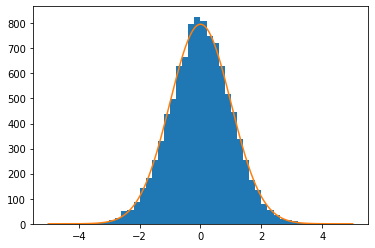

In [9]:
import matplotlib.pyplot as plt

n_bins = 50
range_ = (-5,5)
_ = plt.hist(data_np, bins=n_bins, range=range_)
x = np.linspace(*range_, num=1000)
with gauss.set_norm_range(range_):
    pdf = zfit.run(gauss.pdf(x))
_ = plt.plot(x, data_np.shape[0] / n_bins * (range_[1] - range_[0]) * pdf)

Here, we can see the power of the context managers used to change the normalisation range.

In [10]:
with gauss.set_norm_range((-1e6, 1e6)):  # play around with different norm ranges
# with gauss.set_norm_range((-100, 100)):
    print(zfit.run(gauss.integrate((-0.6, 0.6))))
    print(zfit.run(gauss.integrate((-3, 3))))
    print(zfit.run(gauss.integrate((-100, 100))))

[0.45049021]
[0.99723274]
[1.]


*(remember the orders of magnitude: sigma of our Gaussian is 1, so 100 is far far away)*

The `FitResult` that we obtained contains information about the minimization and can now be used to calculate the errors

In [11]:
print("Function minimum:", minimum.fmin)
print("Converged:", minimum.converged)
print("Full minimizer information:", minimum.info)

Function minimum: -16629.42937369761
Converged: True
Full minimizer information: {'n_eval': 76, 'minuit': <FMin edm=2.1239699778682106e-07 edm_goal=0.001 errordef=0.5 fval=-16629.42937369761 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=76 ngrad=0>
(Param(number=0, name='mu', value=-0.0011329540588028708, error=0.010025123188843632, merror=None, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=True, lower_limit=-1.0, upper_limit=5.0), Param(number=1, name='sigma', value=1.0025142392082251, error=0.0070888166137419995, merror=None, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=True, lower_limit=0.0, upper_limit=5.0))
[[1.00503769e-04 4.40638948e-08]
 [4.40638948e-08 5.02515310e-05]], 'original': <FMin edm=2.12396997786

In [12]:
errors = minimum.error()

/home/jonas/Documents/physics/software/zfit_project/zfit_repo/zfit/minimizers/fitresult.py:1094: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


In [13]:
print(errors[mu])

{'lower': -0.010019251137850503, 'upper': 0.0100315775882997, 'is_valid': True, 'upper_valid': True, 'lower_valid': True, 'at_lower_limit': False, 'at_upper_limit': False, 'nfcn': 12, 'original': <MError number=0 name='mu' lower=-0.010019251137850503 upper=0.0100315775882997 is_valid=True lower_valid=True upper_valid=True at_lower_limit=False at_upper_limit=False at_lower_max_fcn=False at_upper_max_fcn=False lower_new_min=False upper_new_min=False nfcn=12 min=-0.0011329540588028708>, 'cl': 0.6826894921370859}
